# CIFAR-10 Autoencoders: AE and DAE
## Deep Learning and Applications Assignment-2 | Part-1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load CIFAR-10 dataset
transform = transforms.ToTensor()
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_set, val_set = random_split(train_set, [45000, 5000])
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [5]:
# Define improved Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=512):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

In [6]:
# Xavier initialization for reproducibility
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [7]:
# Training function
def train_autoencoder(model, train_loader, val_loader, epochs=50, noise_std=0):
    model.apply(init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    criterion = nn.MSELoss()
    history = []
    best_loss = float('inf')
    best_model = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            x_noisy = torch.clamp(x + noise_std * torch.randn_like(x), 0., 1.) if noise_std > 0 else x
            optimizer.zero_grad()
            outputs, _ = model(x_noisy)
            loss = criterion(outputs, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                x_noisy = torch.clamp(x + noise_std * torch.randn_like(x), 0., 1.) if noise_std > 0 else x
                outputs, _ = model(x_noisy)
                loss = criterion(outputs, x)
                val_loss += loss.item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        history.append(avg_val)
        scheduler.step()

        if avg_val < best_loss:
            best_loss = avg_val
            best_model = model.state_dict()

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

    print(f"Best Val Loss: {best_loss:.4f}")
    model.load_state_dict(best_model)
    return history

In [8]:
# Evaluation metrics
def evaluate_model(model, dataloader):
    model.eval()
    total_ssim, total_psnr, total_mae, total_mse = 0, 0, 0, 0
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            outputs, _ = model(x)
            x = x.cpu().numpy()
            outputs = outputs.cpu().numpy()
            for i in range(len(x)):
                orig = np.transpose(x[i], (1,2,0))
                recon = np.transpose(outputs[i], (1,2,0))
                total_ssim += ssim(orig, recon, channel_axis=2, data_range=1.0)
                total_psnr += psnr(orig, recon, data_range=1.0)
                total_mae += np.mean(np.abs(orig - recon))
                total_mse += np.mean((orig - recon) ** 2)
    n = len(dataloader.dataset)
    print(f"SSIM: {total_ssim/n:.4f}, PSNR: {total_psnr/n:.2f} dB, MAE: {total_mae/n:.4f}, MSE: {total_mse/n:.6f}")

In [9]:
# Visualization
def visualize_reconstructions(model, dataloader, noise_std=0):
    model.eval()
    x, _ = next(iter(dataloader))
    x = x[:8].to(device)
    x_noisy = torch.clamp(x + noise_std * torch.randn_like(x), 0., 1.) if noise_std > 0 else x
    with torch.no_grad():
        recon, _ = model(x_noisy)
    x = x.cpu().numpy()
    x_noisy = x_noisy.cpu().numpy()
    recon = recon.cpu().numpy()
    fig, axs = plt.subplots(3, 8, figsize=(16, 6))
    for i in range(8):
        axs[0, i].imshow(np.transpose(x[i], (1,2,0)))
        axs[0, i].axis('off')
        axs[1, i].imshow(np.transpose(x_noisy[i], (1,2,0)))
        axs[1, i].axis('off')
        axs[2, i].imshow(np.transpose(recon[i], (1,2,0)))
        axs[2, i].axis('off')
    plt.suptitle("Top: Original | Middle: Noisy | Bottom: Reconstructed")
    plt.tight_layout()
    plt.show()


In [9]:
# Visualize latent space
def visualize_latent_space(model, dataloader):
    model.eval()
    all_latents = []
    labels = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            _, latent = model(x)
            all_latents.append(latent.cpu())
            labels.extend(y)
    X = torch.cat(all_latents).numpy()
    y = np.array(labels)
    X_tsne = TSNE(n_components=2, perplexity=30).fit_transform(X)
    X_pca = PCA(n_components=2).fit_transform(X)

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("Latent Space (t-SNE)")

    plt.subplot(1,2,2)
    scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='tab10', s=10)
    plt.title("Latent Space (PCA)")
    plt.show()

Training Standard Autoencoder (AE)...
Epoch [1/50] - Train Loss: 0.0166 | Val Loss: 0.0099
Epoch [2/50] - Train Loss: 0.0083 | Val Loss: 0.0069
Epoch [3/50] - Train Loss: 0.0063 | Val Loss: 0.0057
Epoch [4/50] - Train Loss: 0.0053 | Val Loss: 0.0049
Epoch [5/50] - Train Loss: 0.0047 | Val Loss: 0.0048
Epoch [6/50] - Train Loss: 0.0042 | Val Loss: 0.0039
Epoch [7/50] - Train Loss: 0.0039 | Val Loss: 0.0037
Epoch [8/50] - Train Loss: 0.0037 | Val Loss: 0.0036
Epoch [9/50] - Train Loss: 0.0034 | Val Loss: 0.0034
Epoch [10/50] - Train Loss: 0.0033 | Val Loss: 0.0031
Epoch [11/50] - Train Loss: 0.0031 | Val Loss: 0.0029
Epoch [12/50] - Train Loss: 0.0030 | Val Loss: 0.0029
Epoch [13/50] - Train Loss: 0.0028 | Val Loss: 0.0027
Epoch [14/50] - Train Loss: 0.0027 | Val Loss: 0.0028
Epoch [15/50] - Train Loss: 0.0026 | Val Loss: 0.0025
Epoch [16/50] - Train Loss: 0.0025 | Val Loss: 0.0026
Epoch [17/50] - Train Loss: 0.0024 | Val Loss: 0.0024
Epoch [18/50] - Train Loss: 0.0023 | Val Loss: 0.0023

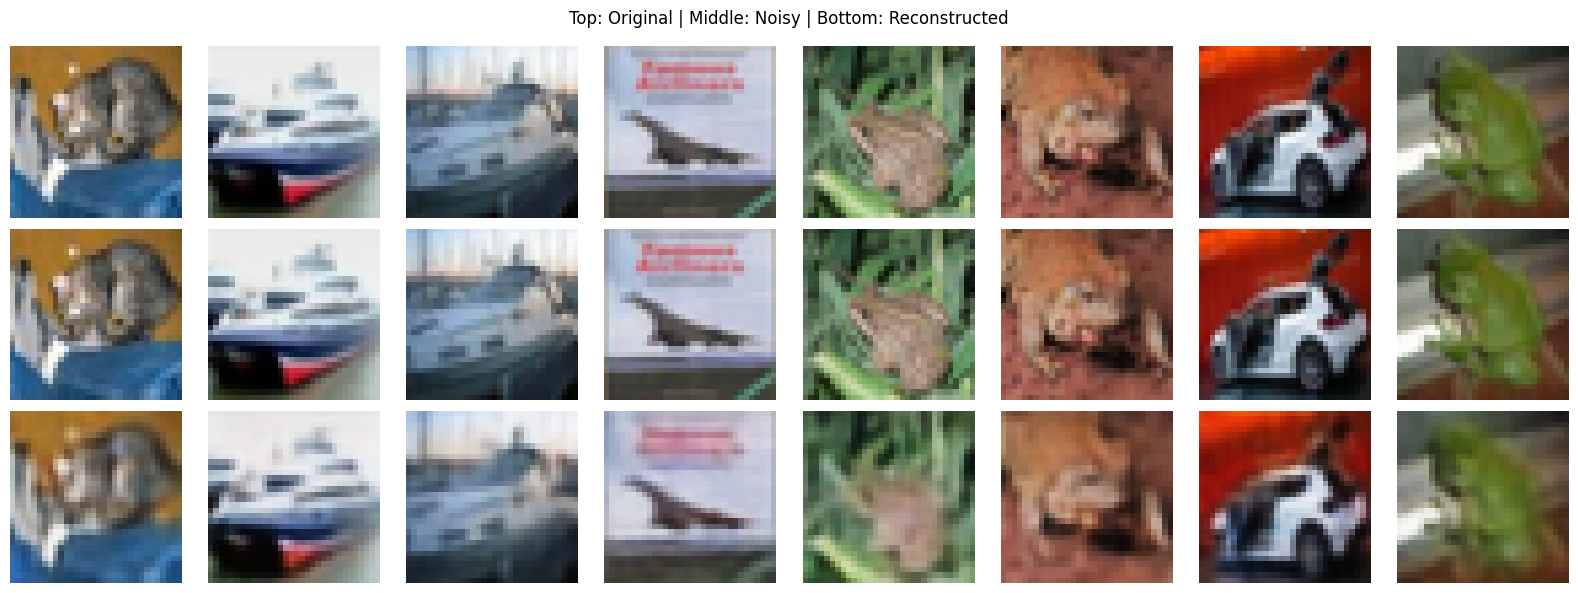

SSIM: 0.9369, PSNR: 29.23 dB, MAE: 0.0264, MSE: 0.001409


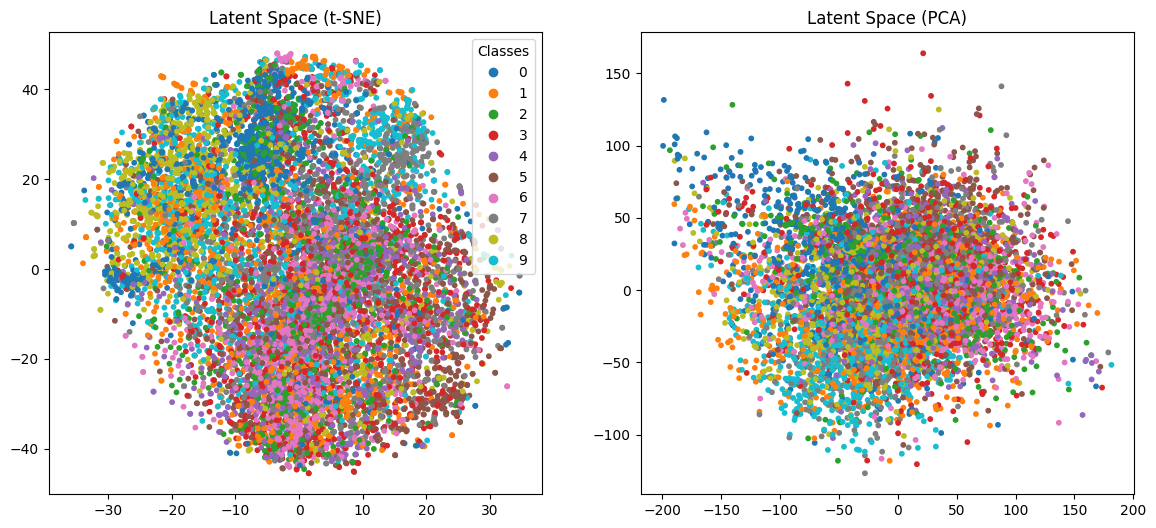

In [10]:
# --- Train AE ---
print("Training Standard Autoencoder (AE)...")
ae = Autoencoder()
hist_ae = train_autoencoder(ae, train_loader, val_loader)
visualize_reconstructions(ae, test_loader)
evaluate_model(ae, test_loader)
visualize_latent_space(ae, test_loader)


Training Denoising Autoencoder (DAE) with σ=0.1...
Epoch [1/30] - Train Loss: 0.0163 | Val Loss: 0.0095
Epoch [2/30] - Train Loss: 0.0082 | Val Loss: 0.0072
Epoch [3/30] - Train Loss: 0.0065 | Val Loss: 0.0068
Epoch [4/30] - Train Loss: 0.0056 | Val Loss: 0.0054
Epoch [5/30] - Train Loss: 0.0051 | Val Loss: 0.0062
Epoch [6/30] - Train Loss: 0.0047 | Val Loss: 0.0045
Epoch [7/30] - Train Loss: 0.0044 | Val Loss: 0.0043
Epoch [8/30] - Train Loss: 0.0041 | Val Loss: 0.0041
Epoch [9/30] - Train Loss: 0.0040 | Val Loss: 0.0040
Epoch [10/30] - Train Loss: 0.0038 | Val Loss: 0.0037
Epoch [11/30] - Train Loss: 0.0037 | Val Loss: 0.0039
Epoch [12/30] - Train Loss: 0.0036 | Val Loss: 0.0035
Epoch [13/30] - Train Loss: 0.0034 | Val Loss: 0.0037
Epoch [14/30] - Train Loss: 0.0034 | Val Loss: 0.0037
Epoch [15/30] - Train Loss: 0.0033 | Val Loss: 0.0032
Epoch [16/30] - Train Loss: 0.0032 | Val Loss: 0.0033
Epoch [17/30] - Train Loss: 0.0031 | Val Loss: 0.0032
Epoch [18/30] - Train Loss: 0.0031 | Va

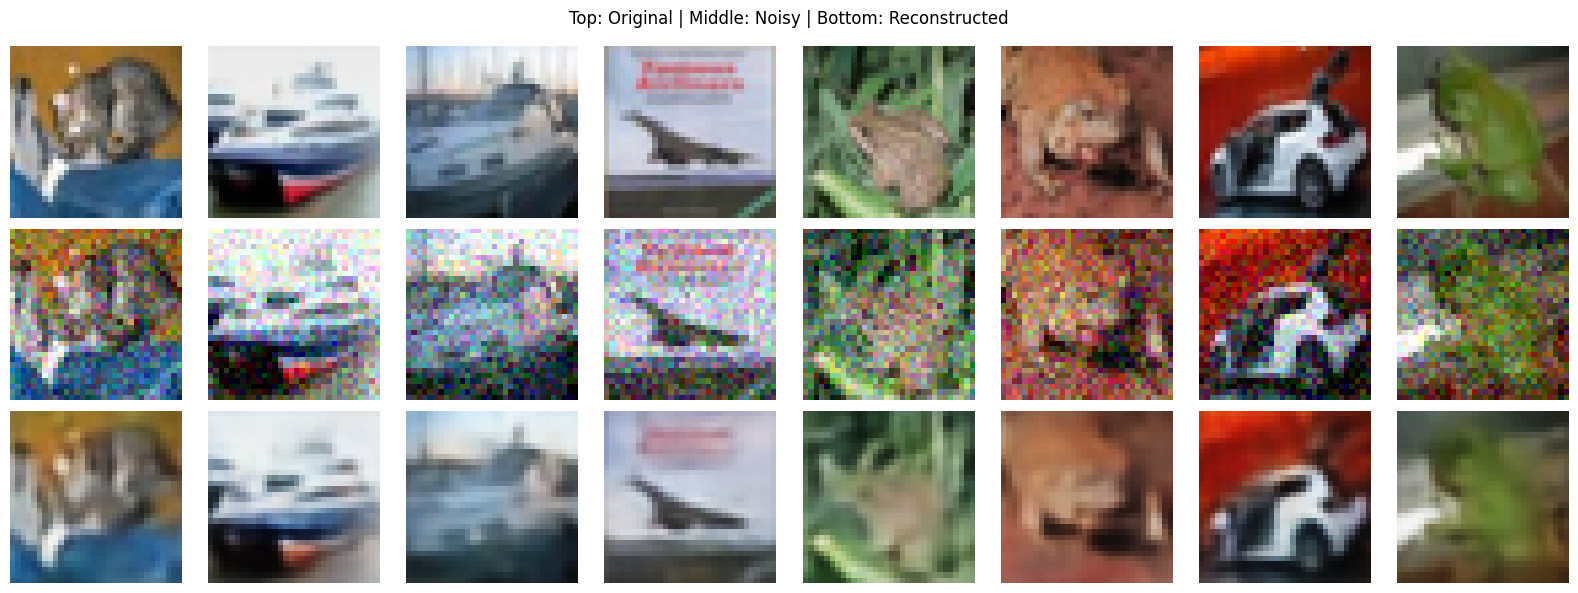

SSIM: 0.8887, PSNR: 27.08 dB, MAE: 0.0333, MSE: 0.002185


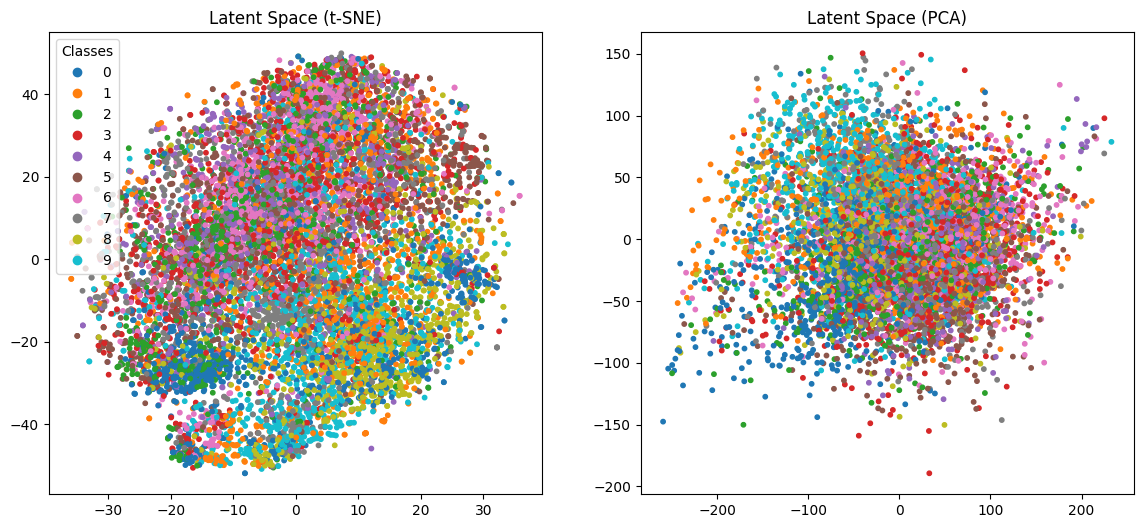

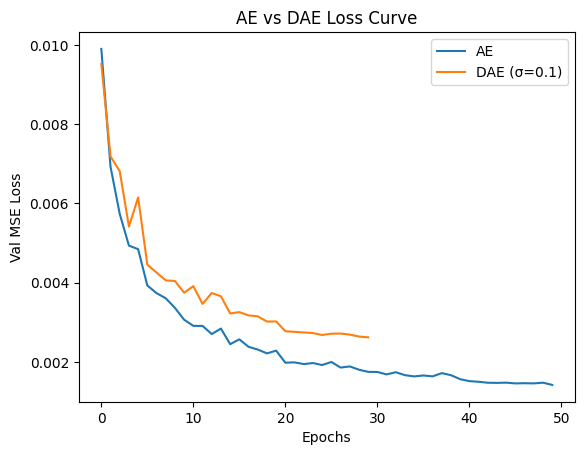


Training Denoising Autoencoder (DAE) with σ=0.3...
Epoch [1/30] - Train Loss: 0.0183 | Val Loss: 0.0123
Epoch [2/30] - Train Loss: 0.0107 | Val Loss: 0.0098
Epoch [3/30] - Train Loss: 0.0092 | Val Loss: 0.0093
Epoch [4/30] - Train Loss: 0.0086 | Val Loss: 0.0085
Epoch [5/30] - Train Loss: 0.0081 | Val Loss: 0.0083
Epoch [6/30] - Train Loss: 0.0078 | Val Loss: 0.0079
Epoch [7/30] - Train Loss: 0.0076 | Val Loss: 0.0074
Epoch [8/30] - Train Loss: 0.0074 | Val Loss: 0.0075
Epoch [9/30] - Train Loss: 0.0073 | Val Loss: 0.0071
Epoch [10/30] - Train Loss: 0.0071 | Val Loss: 0.0070
Epoch [11/30] - Train Loss: 0.0070 | Val Loss: 0.0069
Epoch [12/30] - Train Loss: 0.0069 | Val Loss: 0.0073
Epoch [13/30] - Train Loss: 0.0068 | Val Loss: 0.0070
Epoch [14/30] - Train Loss: 0.0068 | Val Loss: 0.0068
Epoch [15/30] - Train Loss: 0.0067 | Val Loss: 0.0067
Epoch [16/30] - Train Loss: 0.0066 | Val Loss: 0.0067
Epoch [17/30] - Train Loss: 0.0066 | Val Loss: 0.0065
Epoch [18/30] - Train Loss: 0.0065 | Va

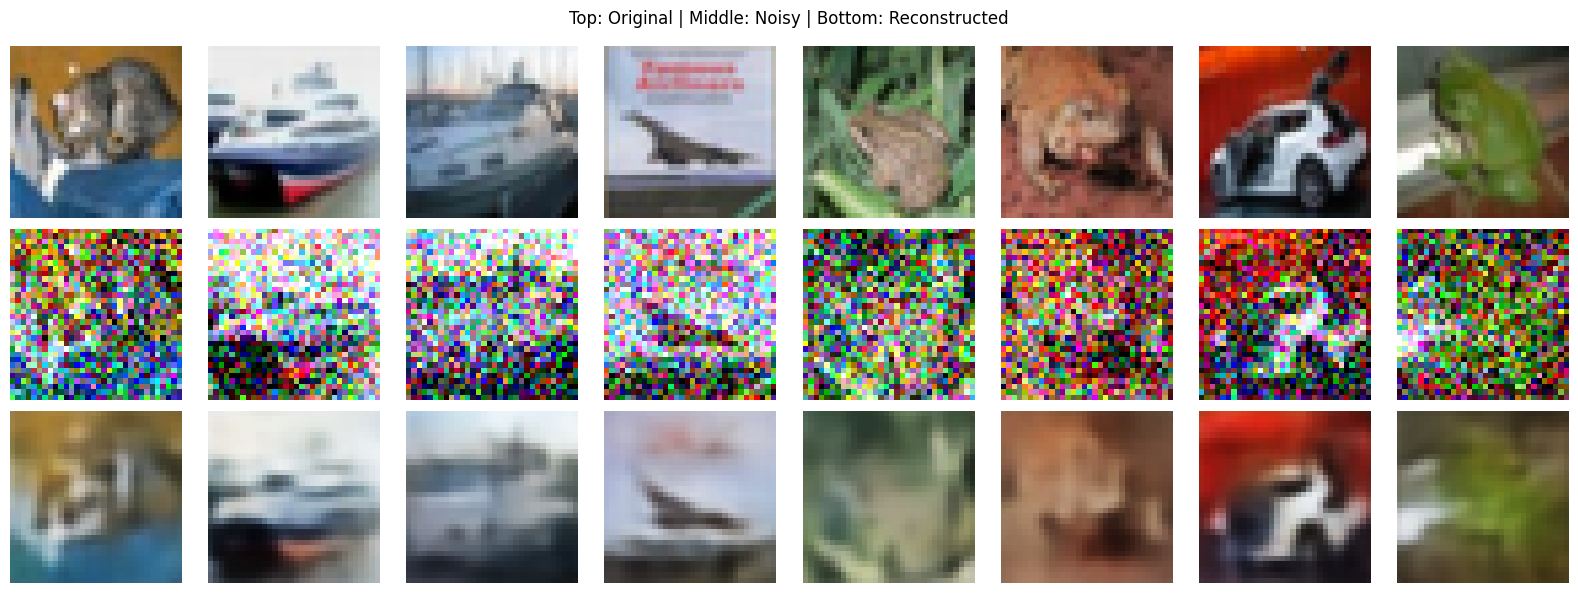

SSIM: 0.7450, PSNR: 22.45 dB, MAE: 0.0581, MSE: 0.006088


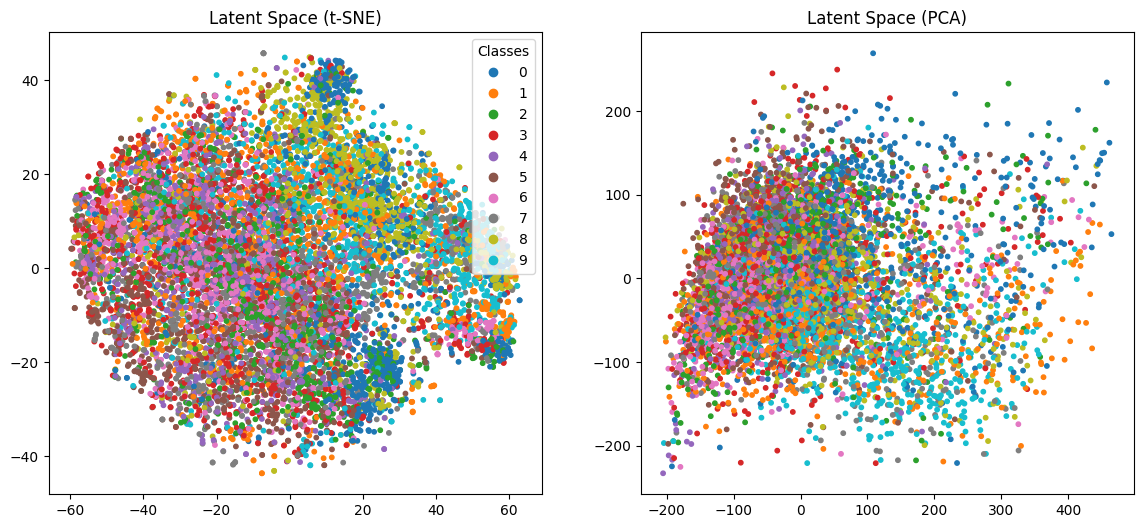

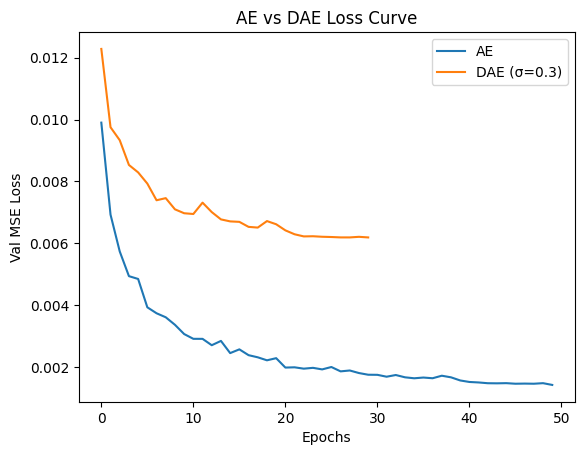


Training Denoising Autoencoder (DAE) with σ=0.5...
Epoch [1/30] - Train Loss: 0.0217 | Val Loss: 0.0160
Epoch [2/30] - Train Loss: 0.0138 | Val Loss: 0.0128
Epoch [3/30] - Train Loss: 0.0124 | Val Loss: 0.0120
Epoch [4/30] - Train Loss: 0.0117 | Val Loss: 0.0115
Epoch [5/30] - Train Loss: 0.0114 | Val Loss: 0.0112
Epoch [6/30] - Train Loss: 0.0111 | Val Loss: 0.0111
Epoch [7/30] - Train Loss: 0.0109 | Val Loss: 0.0108
Epoch [8/30] - Train Loss: 0.0108 | Val Loss: 0.0107
Epoch [9/30] - Train Loss: 0.0106 | Val Loss: 0.0105
Epoch [10/30] - Train Loss: 0.0106 | Val Loss: 0.0105
Epoch [11/30] - Train Loss: 0.0104 | Val Loss: 0.0104
Epoch [12/30] - Train Loss: 0.0103 | Val Loss: 0.0103
Epoch [13/30] - Train Loss: 0.0103 | Val Loss: 0.0103
Epoch [14/30] - Train Loss: 0.0102 | Val Loss: 0.0103
Epoch [15/30] - Train Loss: 0.0102 | Val Loss: 0.0101
Epoch [16/30] - Train Loss: 0.0101 | Val Loss: 0.0101
Epoch [17/30] - Train Loss: 0.0101 | Val Loss: 0.0101
Epoch [18/30] - Train Loss: 0.0100 | Va

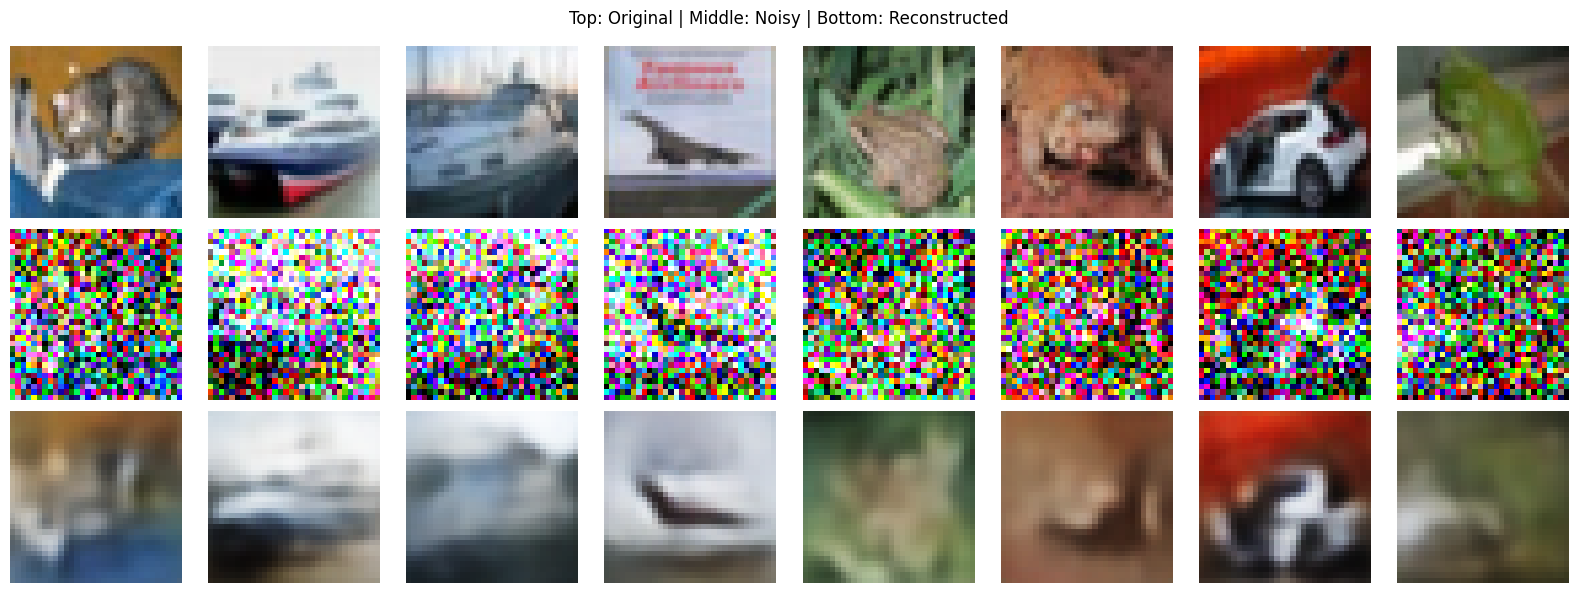

SSIM: 0.6509, PSNR: 18.60 dB, MAE: 0.0955, MSE: 0.014758


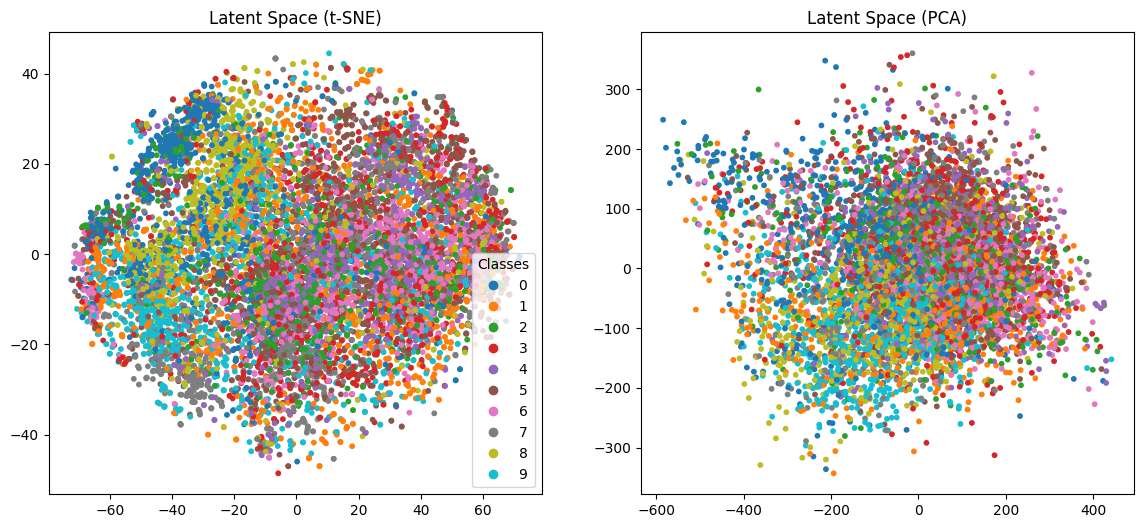

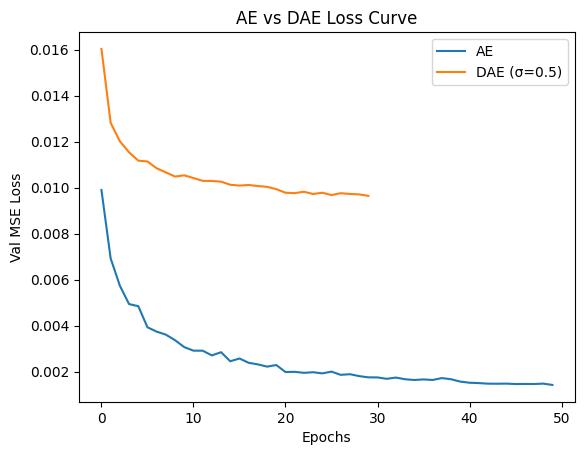

In [11]:
# --- Train DAE for different σ ---
for sigma in [0.1, 0.3, 0.5]:
    print(f"\nTraining Denoising Autoencoder (DAE) with σ={sigma}...")
    dae = Autoencoder()
    hist_dae = train_autoencoder(dae, train_loader, val_loader, epochs=30, noise_std=sigma)
    visualize_reconstructions(dae, test_loader, noise_std=sigma)
    evaluate_model(dae, test_loader)
    visualize_latent_space(dae, test_loader)
    plt.plot(hist_ae, label='AE')
    plt.plot(hist_dae, label=f'DAE (σ={sigma})')
    plt.xlabel('Epochs')
    plt.ylabel('Val MSE Loss')
    plt.title('AE vs DAE Loss Curve')
    plt.legend()
    plt.show()

# PART-II: Variational Autoencoder (VAE) & Latent Space Inference
## Model-2: Variational Autoencoder (VAE)


In [10]:
# VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, 256*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h_dec = self.decoder_fc(z).view(-1, 256, 4, 4)
        out = self.decoder(h_dec)
        return out, mu, logvar, z

In [11]:
# Loss Function
def vae_loss(x, recon, mu, logvar):
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl, recon_loss, kl

In [12]:
# Train VAE
def train_vae(model, loader, epochs=30):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    recon_losses, kl_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_recon, total_kl = 0, 0
        for x, _ in loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon, mu, logvar, _ = model(x)
            loss, recon_loss, kl = vae_loss(x, recon, mu, logvar)
            loss.backward()
            optimizer.step()
            total_recon += recon_loss.item()
            total_kl += kl.item()
        avg_recon = total_recon / len(loader.dataset)
        avg_kl = total_kl / len(loader.dataset)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)
        print(f"Epoch {epoch+1}/{epochs}, Recon Loss: {avg_recon:.4f}, KL Loss: {avg_kl:.4f}")

    return recon_losses, kl_losses

In [13]:
# Evaluation

def evaluate_model(model, dataloader):
    model.eval()
    total_ssim, total_psnr, total_mae, total_mse = 0, 0, 0, 0
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            recon, _, _, _ = model(x)
            x = x.cpu().numpy()
            recon = recon.cpu().numpy()
            for i in range(len(x)):
                orig = np.transpose(x[i], (1,2,0))
                recon_img = np.transpose(recon[i], (1,2,0))
                total_ssim += ssim(orig, recon_img, channel_axis=2, data_range=1.0)
                total_psnr += psnr(orig, recon_img, data_range=1.0)
                total_mae += np.mean(np.abs(orig - recon_img))
                total_mse += np.mean((orig - recon_img) ** 2)
    n = len(dataloader.dataset)
    print(f"SSIM: {total_ssim/n:.4f}, PSNR: {total_psnr/n:.2f}, MAE: {total_mae/n:.4f}, MSE: {total_mse/n:.6f}")

In [14]:
# Latent Interpolation

def interpolate(model, data):
    model.eval()
    x, _ = next(iter(data))
    x = x[:2].to(device)
    with torch.no_grad():
        _, _, _, z = model(x)
    z1, z2 = z[0], z[1]
    interps = []
    for alpha in np.linspace(0, 1, 10):
        z_interp = (1 - alpha) * z1 + alpha * z2
        z_interp = z_interp.unsqueeze(0)
        recon = model.decoder(model.decoder_fc(z_interp).view(-1, 256, 4, 4))
        interps.append(recon.detach().cpu().squeeze().permute(1, 2, 0).numpy())
    fig, axs = plt.subplots(1, 10, figsize=(15,2))
    for i, img in enumerate(interps):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.suptitle("Latent Interpolation")
    plt.show()

In [15]:
# Latent Arithmetic
def latent_arithmetic(model, loader):
    model.eval()
    x, y = next(iter(loader))
    label_map = {v: k for k, v in loader.dataset.class_to_idx.items()}
    targets = {"cat": 3, "dog": 5, "bird": 2}
    images = {name: x[y == idx][0].unsqueeze(0).to(device) for name, idx in targets.items()}
    with torch.no_grad():
        _, _, _, z_cat = model(images["cat"])
        _, _, _, z_dog = model(images["dog"])
        _, _, _, z_bird = model(images["bird"])
        z_result = z_dog - z_cat + z_bird
        recon = model.decoder(model.decoder_fc(z_result).view(-1, 256, 4, 4))
    img = recon.cpu().squeeze().permute(1,2,0).numpy()
    plt.imshow(img)
    plt.title("Latent Arithmetic: dog - cat + bird")
    plt.axis('off')
    plt.show()

In [16]:
# Latent Space Visualization
def visualize_latent_space(model, loader):
    model.eval()
    zs, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, _, _, z = model(x)
            zs.append(z.cpu().numpy())
            labels.append(y.numpy())
    zs = np.concatenate(zs, axis=0)
    labels = np.concatenate(labels, axis=0)
    # Reduce with PCA
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(zs)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=labels, cmap='tab10', s=5)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("Latent Space PCA Visualization")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

Epoch 1/30, Recon Loss: 100.8492, KL Loss: 13.7309
Epoch 2/30, Recon Loss: 66.0740, KL Loss: 17.9564
Epoch 3/30, Recon Loss: 60.9127, KL Loss: 19.1132
Epoch 4/30, Recon Loss: 58.6418, KL Loss: 19.8350
Epoch 5/30, Recon Loss: 57.2641, KL Loss: 20.3404
Epoch 6/30, Recon Loss: 56.3544, KL Loss: 20.6338
Epoch 7/30, Recon Loss: 55.6843, KL Loss: 20.9201
Epoch 8/30, Recon Loss: 55.0892, KL Loss: 21.1178
Epoch 9/30, Recon Loss: 54.5775, KL Loss: 21.3802
Epoch 10/30, Recon Loss: 53.9454, KL Loss: 21.5749
Epoch 11/30, Recon Loss: 53.5055, KL Loss: 21.7736
Epoch 12/30, Recon Loss: 53.1596, KL Loss: 21.9014
Epoch 13/30, Recon Loss: 52.9433, KL Loss: 21.9930
Epoch 14/30, Recon Loss: 52.7874, KL Loss: 22.0379
Epoch 15/30, Recon Loss: 52.5894, KL Loss: 22.1090
Epoch 16/30, Recon Loss: 52.4229, KL Loss: 22.1916
Epoch 17/30, Recon Loss: 52.2313, KL Loss: 22.2876
Epoch 18/30, Recon Loss: 52.0804, KL Loss: 22.3179
Epoch 19/30, Recon Loss: 51.9210, KL Loss: 22.3727
Epoch 20/30, Recon Loss: 51.7851, KL Lo

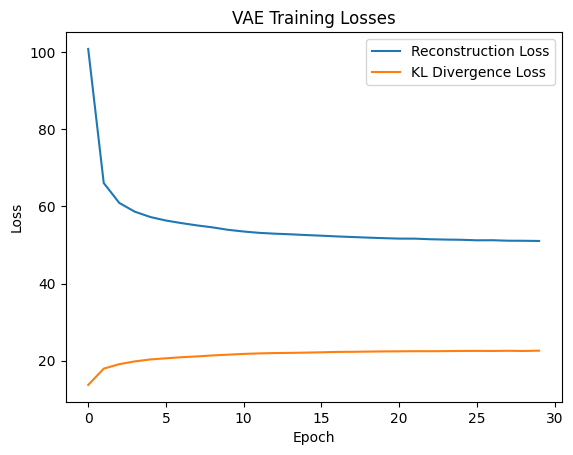

SSIM: 0.4160, PSNR: 18.07, MAE: 0.0977, MSE: 0.016952


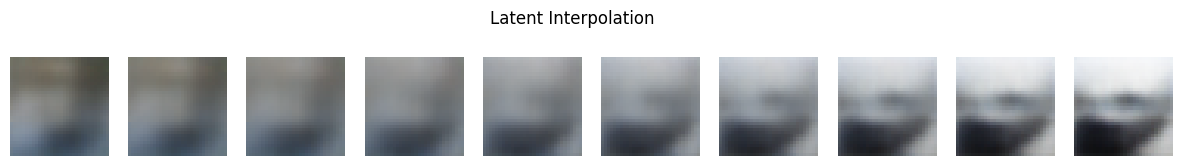

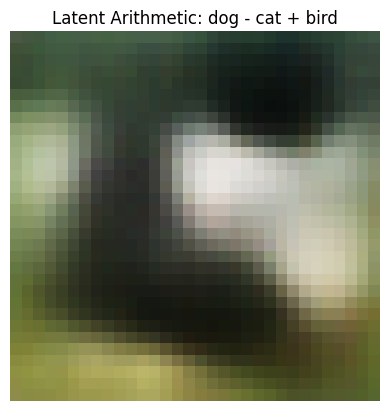

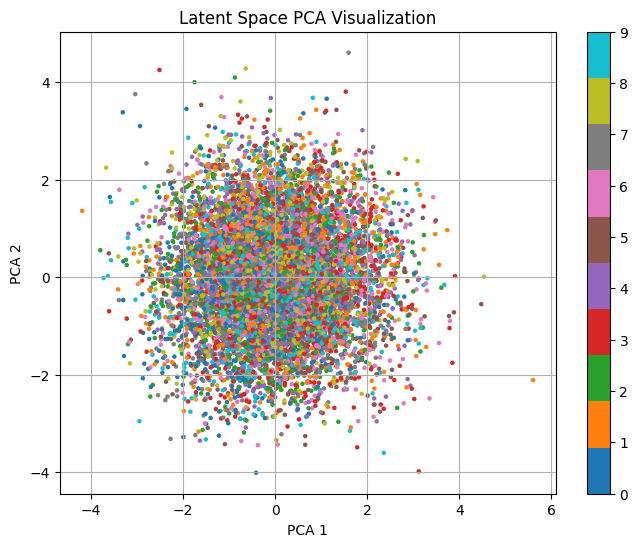

In [17]:
# Instantiate and run
vae = VAE()
recon_losses, kl_losses = train_vae(vae, train_loader)
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Losses")
plt.legend()
plt.show()

evaluate_model(vae, test_loader)
interpolate(vae, test_loader)
latent_arithmetic(vae, test_loader)
visualize_latent_space(vae, test_loader)


# PART - III  
## CIFAR-10 Masked Convolutional Autoencoder (MCAE)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [19]:
# Masked Autoencoder with CNN
class MCAE(nn.Module):
    def __init__(self, mask_ratio=0.25):
        super(MCAE, self).__init__()
        self.mask_ratio = mask_ratio

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def mask_feature_map(self, x):
        B, C, H, W = x.shape
        total_patches = H * W
        num_mask = int(self.mask_ratio * total_patches)
        for b in range(B):
            indices = torch.randperm(total_patches)[:num_mask]
            x[b].view(C, -1)[:, indices] = 0
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        masked = self.mask_feature_map(encoded.clone())
        decoded = self.decoder(masked)
        return decoded, encoded.view(encoded.size(0), -1)


In [20]:
# Train MCAE

def train_mcae(model, loader, epochs=30):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_history = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, _ in loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon, _ = model(x)
            loss = F.mse_loss(recon, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(loader.dataset)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return loss_history

In [21]:
# Evaluate MCAE Reconstruction

def evaluate_mcae(model, loader):
    model.eval()
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            recon, _ = model(x)
            break
    x = x.cpu()
    recon = recon.cpu()
    fig, axs = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        axs[0, i].imshow(np.transpose(x[i], (1, 2, 0)))
        axs[0, i].axis('off')
        axs[1, i].imshow(np.transpose(recon[i], (1, 2, 0)))
        axs[1, i].axis('off')
    plt.suptitle("Original vs Reconstructed (MCAE)")
    plt.show()

In [22]:
# Extract features and evaluate linear classifier

def evaluate_feature_extraction(model, loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, feat = model(x)
            features.append(feat.cpu().numpy())
            labels.append(y.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

In [23]:
# Visualize latent space using PCA and t-SNE

def visualize_latent_space(model, loader):
    model.eval()
    zs, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, z = model(x)
            zs.append(z.cpu().numpy())
            labels.append(y.numpy())
    zs = np.concatenate(zs, axis=0)
    labels = np.concatenate(labels, axis=0)

    # PCA
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(zs)

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    z_tsne = tsne.fit_transform(zs)

    # Side-by-side plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sc1 = axs[0].scatter(z_pca[:, 0], z_pca[:, 1], c=labels, cmap='tab10', s=5)
    axs[0].set_title("Latent Space PCA")
    axs[0].set_xlabel("PCA 1")
    axs[0].set_ylabel("PCA 2")
    axs[0].grid(True)

    sc2 = axs[1].scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels, cmap='tab10', s=5)
    axs[1].set_title("Latent Space t-SNE")
    axs[1].set_xlabel("t-SNE 1")
    axs[1].set_ylabel("t-SNE 2")
    axs[1].grid(True)

    cbar = fig.colorbar(sc2, ax=axs, ticks=range(10), location='right')
    cbar.set_label('Class Labels')
    plt.suptitle("Latent Space Visualization: PCA vs t-SNE")
    plt.tight_layout()
    plt.show()

Epoch 1/30, Loss: 0.0106
Epoch 2/30, Loss: 0.0031
Epoch 3/30, Loss: 0.0019
Epoch 4/30, Loss: 0.0015
Epoch 5/30, Loss: 0.0012
Epoch 6/30, Loss: 0.0011
Epoch 7/30, Loss: 0.0009
Epoch 8/30, Loss: 0.0009
Epoch 9/30, Loss: 0.0008
Epoch 10/30, Loss: 0.0007
Epoch 11/30, Loss: 0.0007
Epoch 12/30, Loss: 0.0006
Epoch 13/30, Loss: 0.0007
Epoch 14/30, Loss: 0.0006
Epoch 15/30, Loss: 0.0006
Epoch 16/30, Loss: 0.0005
Epoch 17/30, Loss: 0.0005
Epoch 18/30, Loss: 0.0005
Epoch 19/30, Loss: 0.0005
Epoch 20/30, Loss: 0.0005
Epoch 21/30, Loss: 0.0005
Epoch 22/30, Loss: 0.0004
Epoch 23/30, Loss: 0.0004
Epoch 24/30, Loss: 0.0004
Epoch 25/30, Loss: 0.0004
Epoch 26/30, Loss: 0.0004
Epoch 27/30, Loss: 0.0004
Epoch 28/30, Loss: 0.0004
Epoch 29/30, Loss: 0.0004
Epoch 30/30, Loss: 0.0004


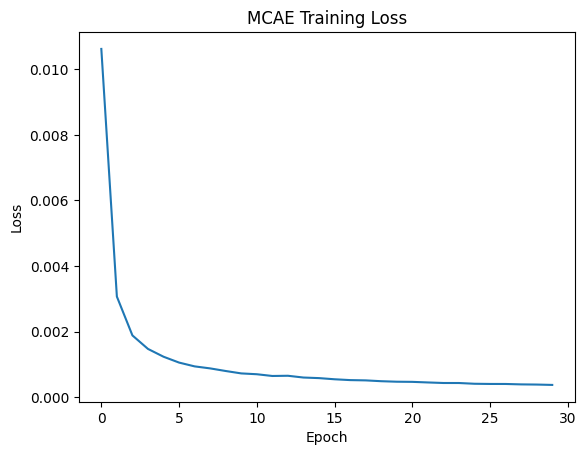

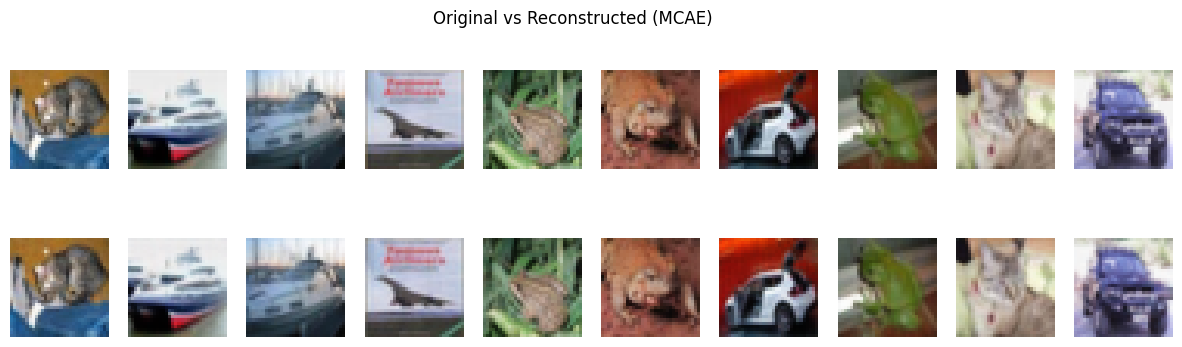

C:\Users\fairo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Classification Accuracy (Frozen Features): 50.56%


In [24]:
# Instantiate and run
mcae = MCAE(mask_ratio=0.25)
losses = train_mcae(mcae, train_loader)
plt.plot(losses)
plt.title("MCAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

evaluate_mcae(mcae, test_loader)

train_features, train_labels = evaluate_feature_extraction(mcae, train_loader)
test_features, test_labels = evaluate_feature_extraction(mcae, test_loader)

clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labels)
pred = clf.predict(test_features)
acc = accuracy_score(test_labels, pred)
print(f"Linear Classification Accuracy (Frozen Features): {acc * 100:.2f}%")

Epoch 1/30, Loss: 0.0108
Epoch 2/30, Loss: 0.0028
Epoch 3/30, Loss: 0.0019
Epoch 4/30, Loss: 0.0015
Epoch 5/30, Loss: 0.0012
Epoch 6/30, Loss: 0.0011
Epoch 7/30, Loss: 0.0010
Epoch 8/30, Loss: 0.0009
Epoch 9/30, Loss: 0.0008
Epoch 10/30, Loss: 0.0008
Epoch 11/30, Loss: 0.0007
Epoch 12/30, Loss: 0.0007
Epoch 13/30, Loss: 0.0007
Epoch 14/30, Loss: 0.0006
Epoch 15/30, Loss: 0.0006
Epoch 16/30, Loss: 0.0006
Epoch 17/30, Loss: 0.0005
Epoch 18/30, Loss: 0.0005
Epoch 19/30, Loss: 0.0005
Epoch 20/30, Loss: 0.0005
Epoch 21/30, Loss: 0.0005
Epoch 22/30, Loss: 0.0005
Epoch 23/30, Loss: 0.0004
Epoch 24/30, Loss: 0.0004
Epoch 25/30, Loss: 0.0004
Epoch 26/30, Loss: 0.0004
Epoch 27/30, Loss: 0.0004
Epoch 28/30, Loss: 0.0004
Epoch 29/30, Loss: 0.0004
Epoch 30/30, Loss: 0.0004


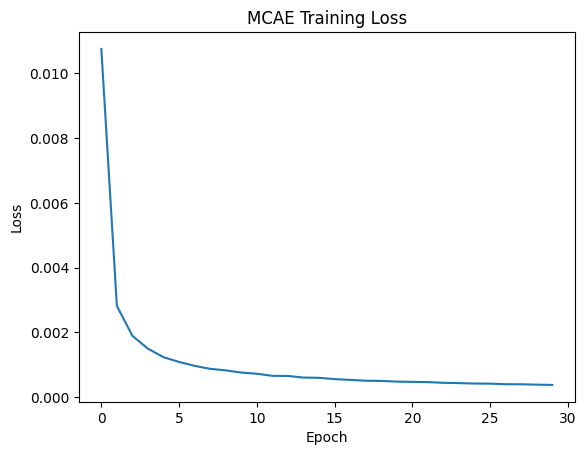

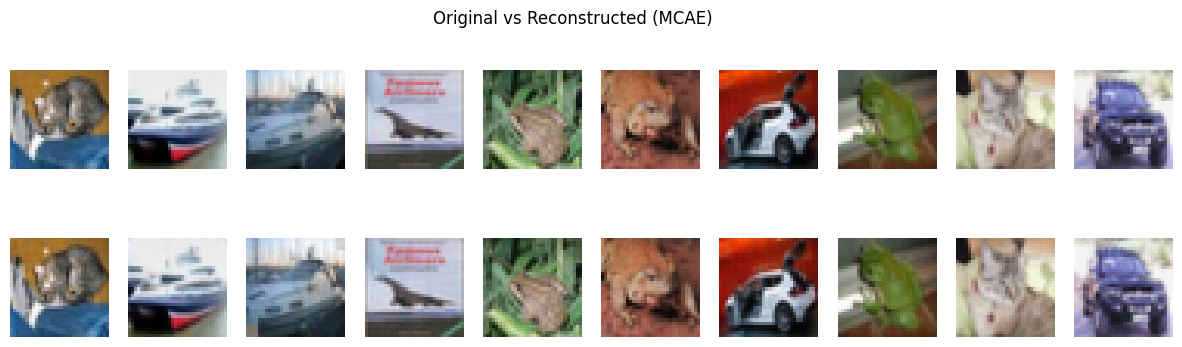

C:\Users\fairo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Classification Accuracy (Frozen Features): 51.46%


C:\Users\fairo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\fairo\AppData\Local\Temp\ipykernel_13564\3762892573.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


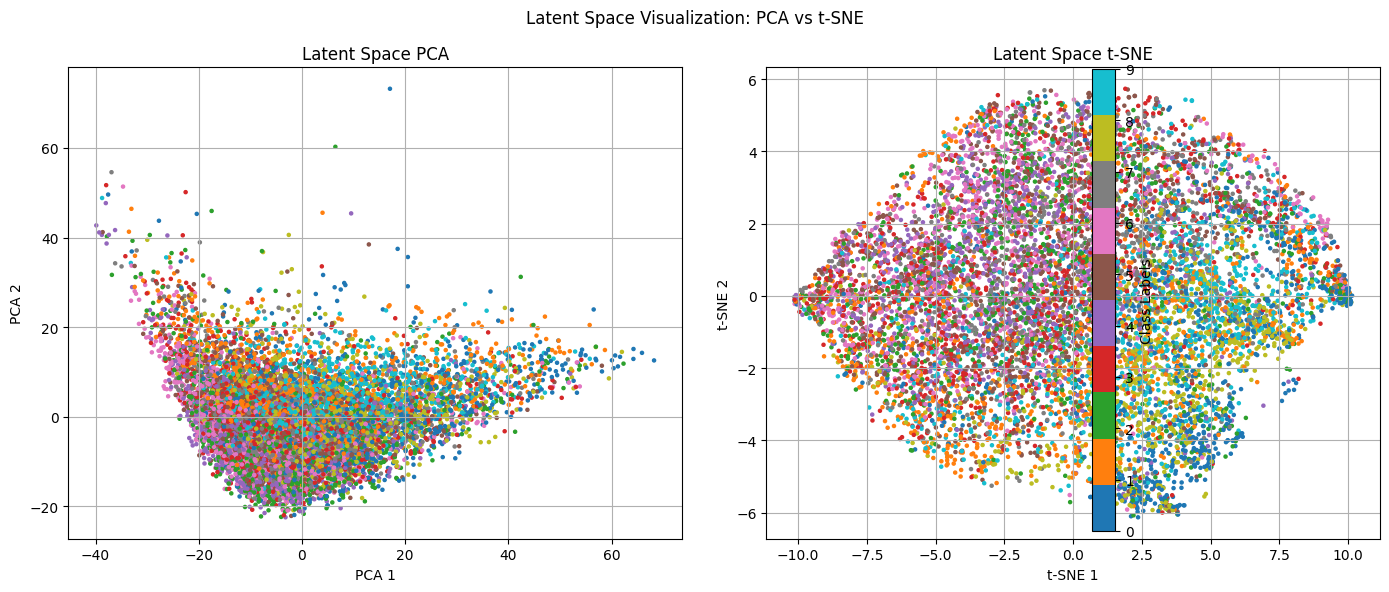

In [25]:
# Instantiate and run
mcae = MCAE(mask_ratio=0.25)
losses = train_mcae(mcae, train_loader)
plt.plot(losses)
plt.title("MCAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

evaluate_mcae(mcae, test_loader)

train_features, train_labels = evaluate_feature_extraction(mcae, train_loader)
test_features, test_labels = evaluate_feature_extraction(mcae, test_loader)

clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labels)
pred = clf.predict(test_features)
acc = accuracy_score(test_labels, pred)
print(f"Linear Classification Accuracy (Frozen Features): {acc * 100:.2f}%")

visualize_latent_space(mcae, test_loader)